In [17]:
from torchvision import datasets, transforms
import torch

_transform_dict = {
    'src': transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     ]),
    'tar': transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     ])}

def load_data(root_path, dir, batch_size=64, phase='src'):
    data = datasets.ImageFolder(root=root_path + dir+'/images', transform=_transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)
    return data_loader

def load_train(root_path, dir, batch_size=64, phase='src'):
    data = datasets.ImageFolder(root=root_path + dir+'/images', transform=_transform_dict[phase])
    train_size = int(0.8 * len(data))
    test_size = len(data) - train_size
    data_train, data_val = torch.utils.data.random_split(data, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)
    val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)
    return train_loader, val_loader

root_path_ ='office31/'
dir_ = 'amazon'
train_loader_, val_loader_ = load_train(root_path_, dir_)
for inputs_, labels_ in train_loader_:
    print(labels_)
    break

tensor([29,  4, 13, 12,  3, 13, 16,  0, 14, 25,  1, 23,  6, 27, 29, 14, 16, 29,
         2, 28, 22, 19, 30, 12,  7, 11,  1, 20,  1, 29, 24, 12, 12,  0, 18, 21,
         6, 21, 30, 27,  5, 25,  2,  9, 22, 23,  3, 14, 28,  7, 18, 17,  8,  2,
         3,  9, 10, 29,  8,  7, 11,  5,  1, 27])


In [18]:
import fairseq
from argparse import Namespace
dict_para = {'model':'resnet', 'batchsize':64, 'cuda':0, 'source':'amazon', 'target': 'webcam'}
args = Namespace(**dict_para)
print(args)
#DEVICE = torch.device('cuda:' + str(args.cuda)                      if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

Namespace(batchsize=64, cuda=0, model='resnet', source='amazon', target='webcam')


In [19]:
from argparse import Namespace

root_dir = 'office31/'
domain = {'src':'amazon', 'tar': 'webcam'}
dataloaders = {}
BATCH_SIZE = {'src': 64, 'tar': int(64)}
dataloaders['tar'] = load_data(
    root_dir, domain['tar'], BATCH_SIZE['tar'], 'tar')
dataloaders['src'], dataloaders['val'] = load_train(
    root_dir, domain['src'], BATCH_SIZE['src'], 'src')


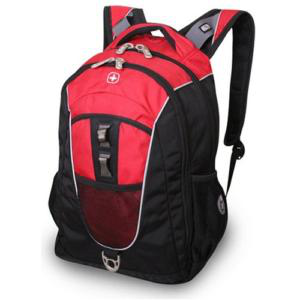

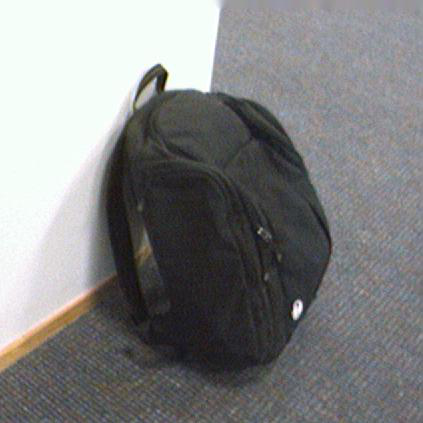

In [20]:
from PIL import Image
import os
str_path = 'office31/amazon/images/back_pack/frame_0092.jpg'

display(Image.open(str_path))

str_path2 = 'office31/webcam/images/back_pack/frame_0001.jpg'

display(Image.open(str_path2))

In [21]:
import torchvision
N_CLASS = 31
LEARNING_RATE = 1e-4
BATCH_SIZE = {'src': int(args.batchsize), 'tar': int(args.batchsize)}
N_EPOCH = 100
MOMENTUM = 0.9
DECAY = 5e-4
def load_model(name='alexnet'):
    if name == 'alexnet':
        model = torchvision.models.alexnet(pretrained=True)
        n_features = model.classifier[6].in_features
        fc = torch.nn.Linear(n_features, N_CLASS)
        model.classifier[6] = fc
        model.fc = model.classifier[6]
    elif name == 'resnet':
        model = torchvision.models.resnet50(pretrained=True)
        n_features = model.fc.in_features
        fc = torch.nn.Linear(n_features, N_CLASS)
        model.fc = fc
    model.fc.weight.data.normal_(0, 0.005)
    model.fc.bias.data.fill_(0.1)
    return model

In [22]:
model = load_model(args.model).to(DEVICE)

In [23]:
import time
import numpy as np    
def get_optimizer(model_name):
    learning_rate = LEARNING_RATE
    if model_name == 'alexnet':
        param_group = [
            {'params': model.features.parameters(), 'lr': learning_rate}]
        for i in range(6):
            param_group += [{'params': model.classifier[i].parameters(),
                             'lr': learning_rate}]
        param_group += [{'params': model.classifier[6].parameters(),
                         'lr': learning_rate * 10}]
    elif model_name == 'resnet':
        param_group = []
        for k, v in model.named_parameters():
            if not k.__contains__('fc'):
                param_group += [{'params': v, 'lr': learning_rate}]
            else:
                param_group += [{'params': v, 'lr': learning_rate * 10}]
    optimizer = torch.optim.SGD(param_group, momentum=MOMENTUM)
    return optimizer


# Schedule learning rate
def lr_schedule(optimizer, epoch):
    def lr_decay(LR, n_epoch, e):
        return LR / (1 + 10 * e / n_epoch) ** 0.75

    for i in range(len(optimizer.param_groups)):
        if i < len(optimizer.param_groups) - 1:
            optimizer.param_groups[i]['lr'] = lr_decay(
                LEARNING_RATE, N_EPOCH, epoch)
        else:
            optimizer.param_groups[i]['lr'] = lr_decay(
                LEARNING_RATE, N_EPOCH, epoch) * 10


def finetune(model, dataloaders, optimizer):

    since = time.time()
    best_acc = 0.0
    acc_hist = []
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, N_EPOCH + 1):
        # lr_schedule(optimizer, epoch)
        print('Learning rate: {:.8f}'.format(optimizer.param_groups[0]['lr']))
        print('Learning rate: {:.8f}'.format(optimizer.param_groups[-1]['lr']))
        for phase in ['src', 'val', 'tar']:
            if phase == 'src':
                model.train()
            else:
                model.eval()
            total_loss, correct = 0, 0
            for inputs, labels in dataloaders[phase]:
                #print('phase', phase, labels)
                #print('dataloaders', dataloaders[s])
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                #print('labels', labels.data)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'src'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                preds = torch.max(outputs, 1)[1]
                if phase == 'src':
                    loss.backward()
                    optimizer.step()
                total_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
                #print('correct', torch.sum(preds == labels.data), preds, labels.data)
            epoch_loss = total_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct.double() / len(dataloaders[phase].dataset)
            acc_hist.append([epoch_loss, epoch_acc])
            print('Epoch: [{:02d}/{:02d}]---{}, loss: {:.6f}, acc: {:.4f}'.format(epoch, N_EPOCH, phase, epoch_loss,
                                                                                  epoch_acc))
            if phase == 'tar' and epoch_acc > best_acc:
                best_acc = epoch_acc
        print()
        fname = 'finetune_result' + args.model + \
            str(LEARNING_RATE) + str(args.source) + \
            '-' + str(args.target) + '.csv'
        np.savetxt(fname, np.asarray(a=acc_hist, dtype=float), delimiter=',',
                   fmt='%.4f')
    time_pass = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_pass // 60, time_pass % 60))

    return model, best_acc, acc_hist

In [24]:
optimizer = get_optimizer(args.model)
model_best, best_acc, acc_hist = finetune(model, dataloaders, optimizer)
print('{}Best acc: {}'.format('*' * 10, best_acc))

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [01/100]---src, loss: 3.273197, acc: 0.1935
Epoch: [01/100]---val, loss: 3.005989, acc: 0.5177
Epoch: [01/100]---tar, loss: 3.046219, acc: 0.4491

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [02/100]---src, loss: 2.782736, acc: 0.5335
Epoch: [02/100]---val, loss: 2.493300, acc: 0.6028
Epoch: [02/100]---tar, loss: 2.577193, acc: 0.5396

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [03/100]---src, loss: 2.293043, acc: 0.6396
Epoch: [03/100]---val, loss: 2.020499, acc: 0.6738
Epoch: [03/100]---tar, loss: 2.162733, acc: 0.6214

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [04/100]---src, loss: 1.892426, acc: 0.6902
Epoch: [04/100]---val, loss: 1.677395, acc: 0.7199
Epoch: [04/100]---tar, loss: 1.842069, acc: 0.6969

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [05/100]---src, loss: 1.597141, acc: 0.7137
Epoch: [05/100]---val, loss: 1.474746, acc: 0.7252
Epoch: [05/100]---tar,

Epoch: [41/100]---src, loss: 0.448974, acc: 0.8775
Epoch: [41/100]---val, loss: 0.706799, acc: 0.8103
Epoch: [41/100]---tar, loss: 0.891743, acc: 0.7459

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [42/100]---src, loss: 0.448704, acc: 0.8824
Epoch: [42/100]---val, loss: 0.674699, acc: 0.8032
Epoch: [42/100]---tar, loss: 0.866249, acc: 0.7497

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [43/100]---src, loss: 0.452585, acc: 0.8762
Epoch: [43/100]---val, loss: 0.683905, acc: 0.8085
Epoch: [43/100]---tar, loss: 0.864068, acc: 0.7484

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [44/100]---src, loss: 0.435775, acc: 0.8824
Epoch: [44/100]---val, loss: 0.674517, acc: 0.8085
Epoch: [44/100]---tar, loss: 0.853604, acc: 0.7535

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [45/100]---src, loss: 0.453728, acc: 0.8855
Epoch: [45/100]---val, loss: 0.632600, acc: 0.8262
Epoch: [45/100]---tar, loss: 0.891387, acc: 0.7447

Learning rate: 0.00010

Epoch: [81/100]---src, loss: 0.279082, acc: 0.9294
Epoch: [81/100]---val, loss: 0.600171, acc: 0.8369
Epoch: [81/100]---tar, loss: 0.928801, acc: 0.7358

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [82/100]---src, loss: 0.244136, acc: 0.9370
Epoch: [82/100]---val, loss: 0.608677, acc: 0.8316
Epoch: [82/100]---tar, loss: 0.905780, acc: 0.7321

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [83/100]---src, loss: 0.278802, acc: 0.9290
Epoch: [83/100]---val, loss: 0.629771, acc: 0.8209
Epoch: [83/100]---tar, loss: 0.931206, acc: 0.7245

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [84/100]---src, loss: 0.259262, acc: 0.9316
Epoch: [84/100]---val, loss: 0.591843, acc: 0.8422
Epoch: [84/100]---tar, loss: 0.895499, acc: 0.7396

Learning rate: 0.00010000
Learning rate: 0.00100000
Epoch: [85/100]---src, loss: 0.255339, acc: 0.9392
Epoch: [85/100]---val, loss: 0.597106, acc: 0.8245
Epoch: [85/100]---tar, loss: 0.918347, acc: 0.7384

Learning rate: 0.00010

In [62]:
#print(acc_hist)
print(acc_hist[0], len(acc_hist), acc_hist[0][1].cpu().numpy())
print(len(acc_hist[::3]), acc_hist[::3][0][1].float())

#src, val, test losses
print([a[0] for a in acc_hist[::3][:10]])
print([a[0] for a in acc_hist[1::3][:10]])
print([a[0] for a in acc_hist[2::3][:10]])

#src, val, test acc
print([a[1].cpu().numpy() for a in acc_hist[::3][:10]])
print([a[1].cpu().numpy() for a in acc_hist[1::3][:10]])
print([a[1].cpu().numpy() for a in acc_hist[2::3][:10]])

[2.2652340855960365, tensor(0.4137, device='cuda:0', dtype=torch.float64)] 300 0.41367066134043495
100 tensor(0.4137, device='cuda:0')
[2.2652340855960365, 1.2769385378095133, 1.1397301662089927, 0.9843407445519011, 0.9434369196110813, 0.8777954484217441, 0.7565527190328226, 0.769047603943694, 0.6907952248230015, 0.6957411449113212]
[1.5183442754948393, 1.3008460905535002, 1.289514315043781, 1.191361590480128, 1.2718473672866821, 1.1410021097102063, 1.115190329281151, 1.1226911768845633, 1.0966843205986294, 1.1514402602581268]
[1.9954608729800338, 1.8551216426885353, 1.915418659965947, 1.8490793853435876, 1.8543755355870948, 1.847930235232947, 1.8312538343405573, 1.9044217483052668, 1.8555478937221024, 1.9499834948365793]
[array(0.41367066), array(0.63692854), array(0.66932978), array(0.72791833), array(0.72924989), array(0.74522858), array(0.78428762), array(0.78473147), array(0.79627164), array(0.79538393)]
[array(0.62056738), array(0.65957447), array(0.63652482), array(0.68262411), 

In [26]:
import matplotlib.pyplot as plt
import numpy as np

help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

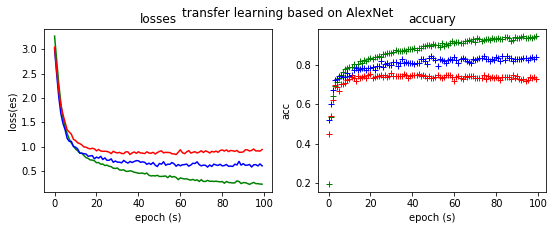

In [27]:

# Fixing random state for reproducibility
np.random.seed(19680801)


# create some data to use for the plot

t = np.arange(0, 100)
#fig, axis = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig, axis = plt.subplots(nrows=1, ncols=2,  figsize=(9, 3),sharex=True)

src_loss_ = [a[0] for a in acc_hist[::3]]
val_loss_ = [a[0] for a in acc_hist[1::3]]
test_loss_ = [a[0] for a in acc_hist[2::3]]
#print(src_loss_[:10])
# the main axes is subplot(111) by default
axis[0].plot(t, src_loss_,'g',label='loss_train' )
axis[0].plot(t, val_loss_, 'b',label='loss_val')
axis[0].plot(t, test_loss_, 'r',label='loss_test(transfer)')
axis[0].set_title('losses')
axis[0].set_xlabel('epoch (s)')
axis[0].set_ylabel('loss(es)')
src_acc_ = [a[1].cpu().numpy() for a in acc_hist[::3]]
val_acc_ = [a[1].cpu().numpy() for a in acc_hist[1::3]]
test_acc_ = [a[1].cpu().numpy() for a in acc_hist[2::3]]
#print(src_acc_[:10])
# the main axes is subplot(111) by default
axis[1].plot(t, src_acc_,'g+' ,label='acc_train')
axis[1].plot(t, val_acc_, 'b+',label='acc_val')
axis[1].plot(t, test_acc_, 'r+',label='acc_test(transfer)')
axis[1].set_title('accuary')
#plt.axis([0, 100, 1, 1.1 * np.min(s), 2 * np.max(s)])
axis[1].set_xlabel('epoch (s)')
axis[1].set_ylabel('acc')
#plt.ylabel('loss(s)')
#plt.title('transfer learning based on AlexNet')
fig.suptitle('transfer learning based on AlexNet')

plt.show()

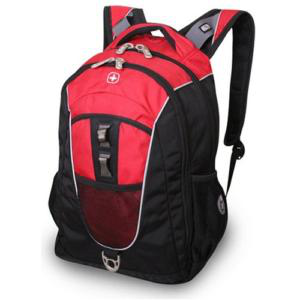

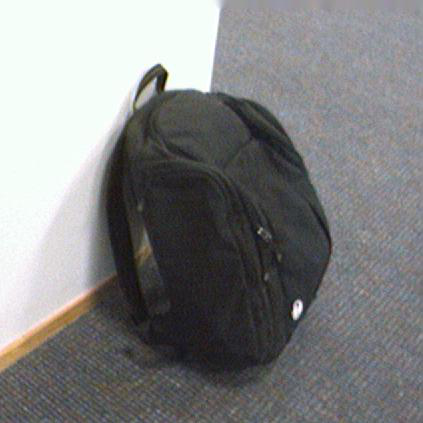

In [11]:
#test_data = load_data('office31/', 'amazon/images/back_pack',batch_size=64, phase='src')
#root_path_dir_ = 'office31/amazon/images/back_pack'
root_path_dir_ = 'office31/amazon/images'

data_ = datasets.ImageFolder(root=root_path_dir_, transform=_transform_dict['src'])
data_loader_ = torch.utils.data.DataLoader(data_, batch_size=64, shuffle=True, drop_last=False, num_workers=4)
print(data_loader_)
#help(data_)
print(data_.classes)
print(data_.imgs[:3])
#help(data_loader_)
print(data_loader_.__len__, data_loader_.__dict__)

['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']
[('office31/amazon/images/back_pack/frame_0001.jpg', 0), ('office31/amazon/images/back_pack/frame_0002.jpg', 0), ('office31/amazon/images/back_pack/frame_0003.jpg', 0)]
<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x7f0d60907630>> {'dataset': Dataset ImageFolder
    Number of datapoints: 2817
    Root location: office31/amazon/images
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               